In [10]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import pandas as pd

In [11]:
# Number of clusters and their colors
n_clusters = 4
colors = ['red', 'green', 'blue', 'purple']

# Generate a synthetic dataset with minimal overlap between clusters
X, y = make_blobs(n_samples=100, centers=n_clusters, n_features=2, cluster_std=0.3, random_state=0, center_box=(-20.0, 20.0))

# Create a DataFrame to hold the dataset
df = pd.DataFrame(X, columns=['x', 'y'])

# Mapping from cluster label to color and replacing cluster labels with colors in the DataFrame
cluster_color_map = {i: colors[i] for i in range(n_clusters)}
df['cluster'] = [cluster_color_map[label] for label in y]

df['id'] = [f"id{i+1}" for i in range(df.shape[0])]

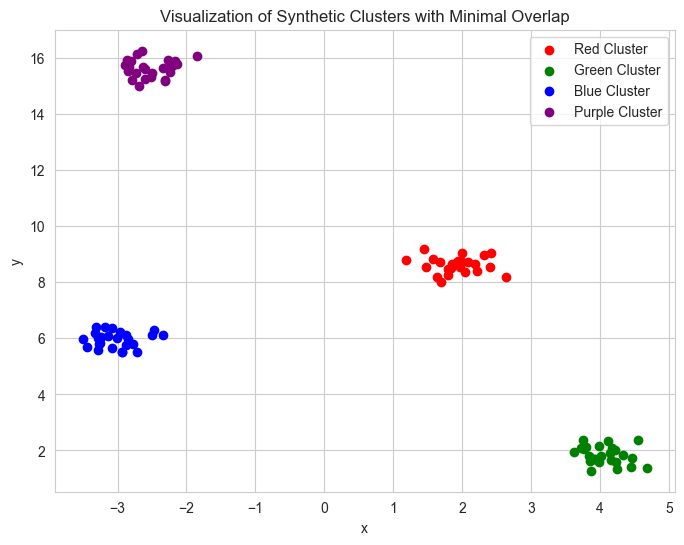

In [12]:
# Visualization of the clusters with distinct colors
plt.figure(figsize=(8, 6))
for color in colors:
    # Select data points belonging to each cluster/color
    cluster_data = df[df['cluster'] == color]
    plt.scatter(cluster_data['x'], cluster_data['y'], color=color, label=f'{color.capitalize()} Cluster')

plt.title('Visualization of Synthetic Clusters with Minimal Overlap')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [13]:
# Save the DataFrame to CSV
csv_file_path = './data/synthetic_clusters_colored.csv'
df.to_csv(csv_file_path, index=False)